In [1]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats

http://www.jstor.org/stable/40928158
En este artículo hay un estudio de una tribu de Tasmania llevado a cabo por una antropóloga

In [3]:
people = pd.read_csv("./data/Howell1.csv", delimiter=';')
people

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


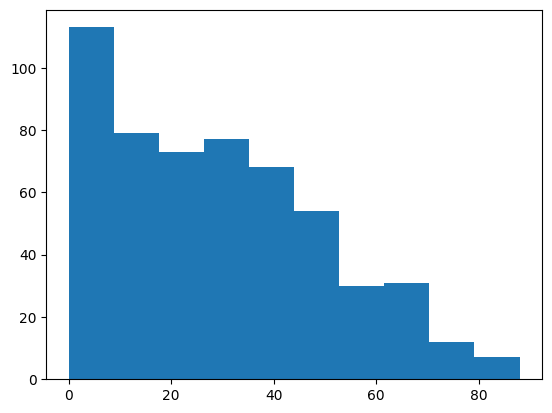

In [5]:
plt.hist(people.age);

In [7]:
people.describe().T

,count,mean,std,min,25%,50%,75%,max
height,544.0,138.263596,27.602448,53.975000,125.095000,148.590000,157.480000,179.070000
weight,544.0,35.610618,14.719178,4.252425,22.007717,40.057844,47.209005,62.992589
age,544.0,29.344393,20.746888,0.000000,12.000000,27.000000,43.000000,88.000000
male,544.0,0.472426,0.499699,0.000000,0.000000,0.000000,1.000000,1.000000


In [9]:
df = people[people["age"] >= 18]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
height,352.0,154.597093,7.742332,136.525000,148.59000,154.30500,160.655000,179.070000
weight,352.0,44.990486,6.456708,31.071052,40.25629,44.79221,49.292693,62.992589
age,352.0,41.138494,15.967855,18.000000,28.00000,39.00000,51.000000,88.000000
male,352.0,0.468750,0.499733,0.000000,0.00000,0.00000,1.000000,1.000000


In [14]:
az.summary(df.to_dict(orient = "list"),kind="stats")

,mean,sd,hdi_3%,hdi_97%
height,154.597,7.742,139.700,167.005
weight,44.990,6.457,34.189,57.068
age,41.138,15.968,18.000,69.000
male,0.469,0.500,0.000,1.000


## Regresión altura vs peso

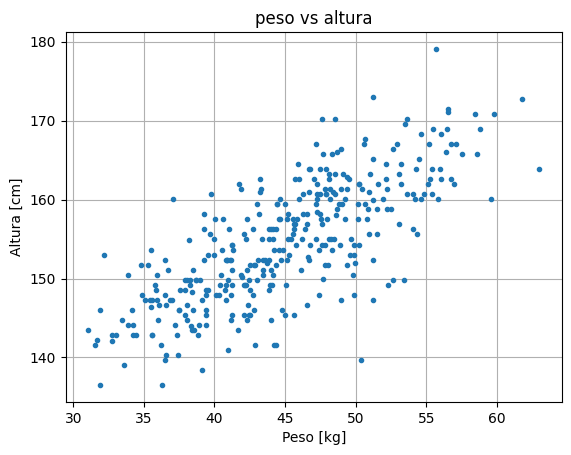

In [26]:
_,ax = plt.subplots()
ax.plot(df.weight,df.height, '.')
ax.set_xlabel("Peso [kg]")
ax.set_ylabel("Altura [cm]")
ax.set_title("peso vs altura")
ax.grid();

In [1]:
mean_weight = df.weight.values.mean()
with pm.Model() as model:
    # mu = función lineal del peso
    # altura = una instancia de nomral con meida mu y cierto sigma para el peos en cuestion 
    b0 = pm.Normal("b0",mu = df.height.values.mean(),sigma = 50)
    b1 = pm.Uniform("b1",-10,10)
    epsilon = pm.Uniform("epsilon",0,100)
    mu = b0 + b1*(df.weight.values - mean_weight)
    height = pm.Normal("height",mu = mu, sigma = epsilon, observed = df.height.values ) 
    trace = pm.sample(1_000,tune = 1_000)
model 

NameError: name 'df' is not defined

In [ ]:
df.height.values.mean()

154.5970926136364

In [ ]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,154.597,0.274,154.072,155.099,0.003,0.002,6181.0,2956.0,1.0
b1,0.905,0.042,0.827,0.985,0.001,0.000,6255.0,3335.0,1.0
epsilon,5.099,0.194,4.745,5.469,0.003,0.002,5723.0,2943.0,1.0


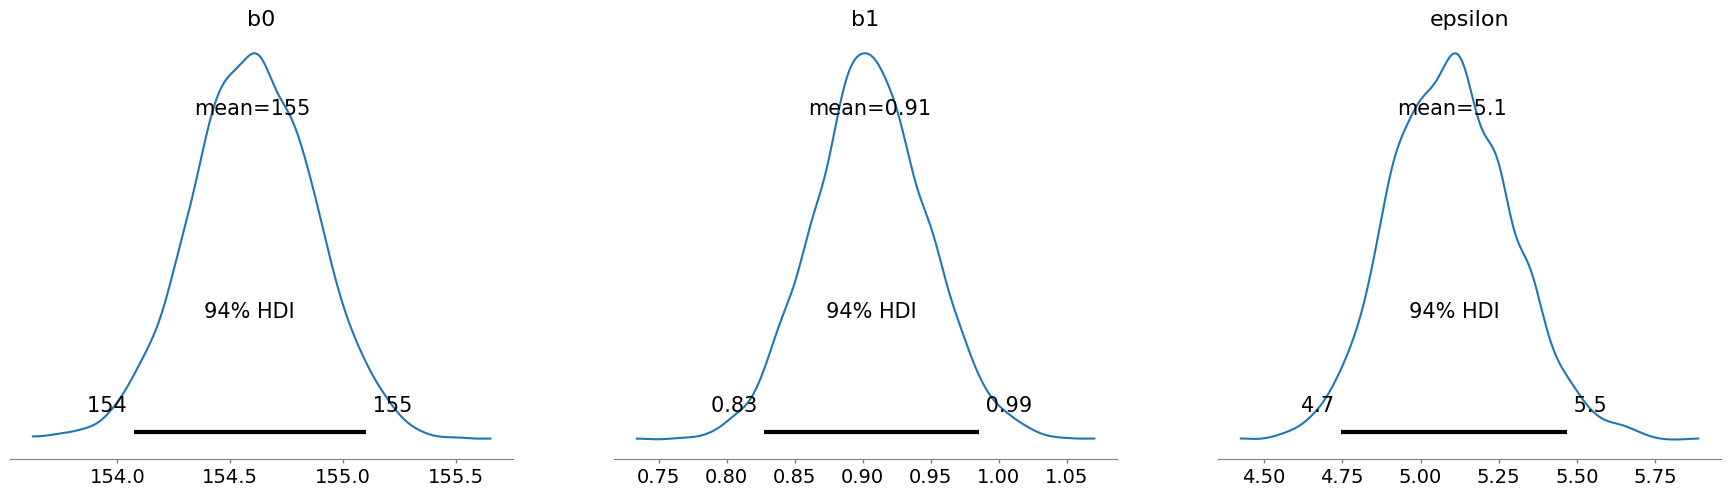

In [ ]:
az.plot_posterior(trace);

In [ ]:
df_traces = trace.posterior.to_dataframe().reset_index()
b0_samples = df_traces["b0"].values
b0_samples

array([154.46099886, 154.79401012, 154.41146256, ..., 154.61785947,
       154.78801748, 154.45049813])

In [ ]:
b0_samples = np.array(trace.posterior.b0).flatten()
b1_samples = np.array(trace.posterior.b1).flatten()

Vamos a incorporar la información de nuestro ajuste lineal al gráfico que teníamos antes

In [ ]:
index = 0
b0 = b0_samples[index]
b1 = b1_samples[index]
b0,b1
mu = b0 + b1*df.weight.values

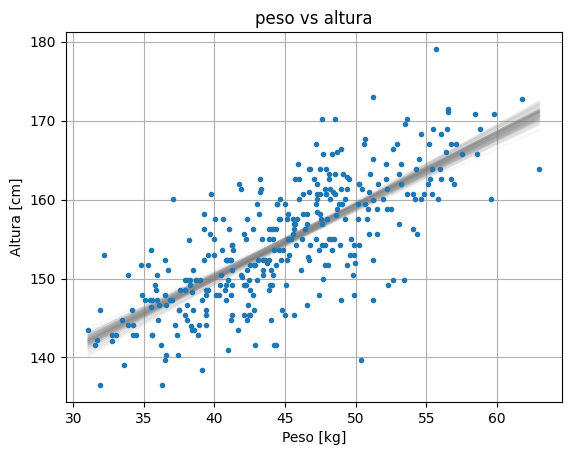

In [ ]:
N_traces_to_plot = 100
_,ax = plt.subplots()

for index in range(N_traces_to_plot):

    b0 = b0_samples[index]
    b1 = b1_samples[index]
    mu = b0 + b1*(df.weight.values - mean_weight)
    ax.plot(df.weight,mu,c = "grey", alpha = .05)

ax.plot(df.weight,df.height, '.')
ax.set_xlabel("Peso [kg]")
ax.set_ylabel("Altura [cm]")
ax.set_title("peso vs altura")
ax.grid();

## Posterior predictive
Supongamos que una persona pesa 50 kg. ¿Cuánto esperamos que esta persona mida a partir de los ajustes que hicimos?

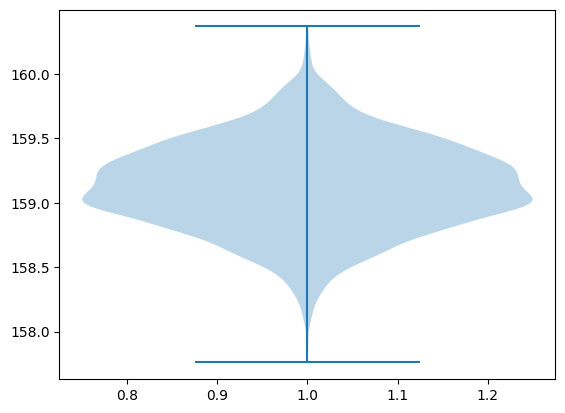

In [ ]:
# NO va a ser esto:
weight0 = 50
mu50 = b0_samples + b1_samples*(weight0 - mean_weight)
plt.violinplot(mu50);

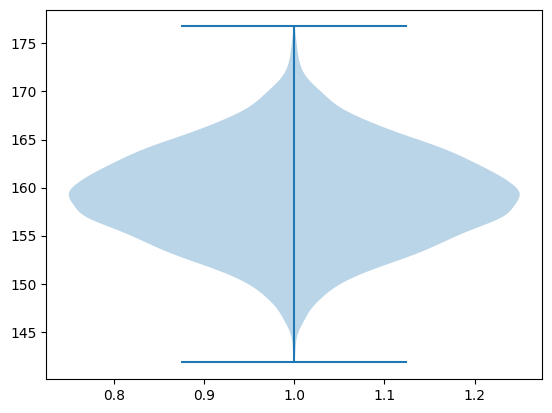

In [ ]:
plt.violinplot(stats.norm.rvs(mu50,5));

In [ ]:
epsilon_samples = np.array(trace.posterior.epsilon).flatten()

In [ ]:
weight0 = 50
iterations = 1_000
heights = np.zeros(iterations)
for _ in range(iterations):    
    index = np.random.randint(len(b0_samples))
    b0 = b0_samples[index]
    b1 = b1_samples[index]
    mu = b0 + b1*(weight0 - mean_weight)
    epsilon = epsilon_samples[index]
    heights[_] = stats.norm.rvs(mu,epsilon)

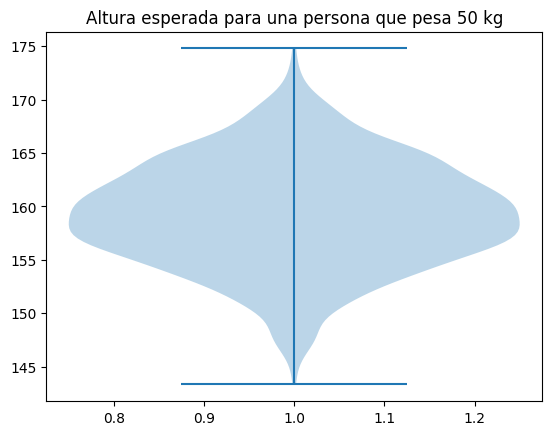

In [ ]:
plt.violinplot(heights)
plt.title("Altura esperada para una persona que pesa 50 kg");

## Trazamos incluyendo el error
Agregamos a nuestro gráfico de peso vs altura las trazas que tienen en cuenta el error de medición. De esta forma, vamos a esperar que las trazas "incluyan" a los puntos medidos.

In [ ]:
df = df.sort_values(by='weight').reset_index(drop=True)

In [ ]:
iterations = 1_000
heights = np.zeros([iterations,len(df)])
for _ in range(iterations):    
    index = np.random.randint(len(b0_samples))
    b0 = b0_samples[index]
    b1 = b1_samples[index]
    mu = b0 + b1*(df.weight.values - mean_weight)
    epsilon = epsilon_samples[index]
    heights[_] = stats.norm.rvs(mu,epsilon)

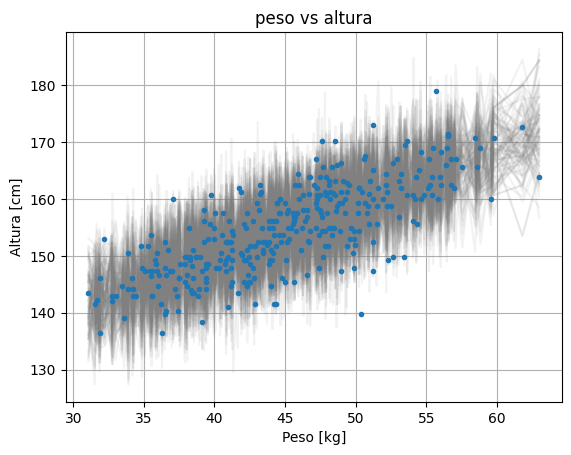

In [ ]:
heights[0,:].shape
N_traces_to_plot = 100
_,ax = plt.subplots()

for _ in range(N_traces_to_plot):
    index = np.random.randint(iterations)
    ax.plot(df.weight,heights[index,:],c = "grey", alpha = .1)

ax.plot(df.weight,df.height, '.')
ax.set_xlabel("Peso [kg]")
ax.set_ylabel("Altura [cm]")
ax.set_title("peso vs altura")
ax.grid();

In [ ]:
hdis = az.hdi(heights,hdi_prob=.90)

/tmp/ipykernel_22008/930198266.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdis = az.hdi(heights,hdi_prob=.90)


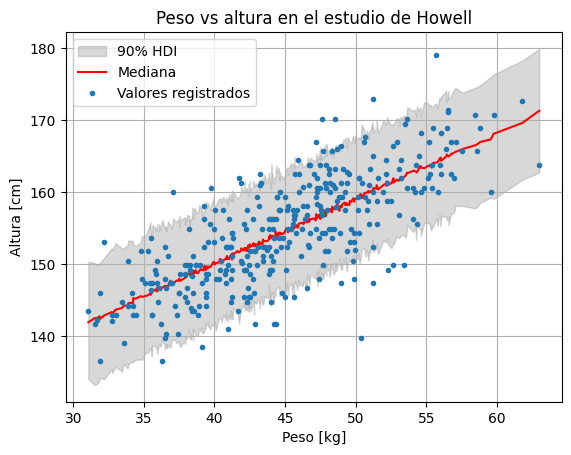

In [ ]:
heights[0,:].shape
N_traces_to_plot = 100
_,ax = plt.subplots()
ax.fill_between(
    df.weight.values,
    hdis[:,0],
    hdis[:,1],
    label = "90% HDI",
    color = "grey",
    alpha = .3)

ax.plot(df.weight,np.percentile(heights,50,axis = 0),
        label = "Mediana",
        color = "red")
ax.plot(df.weight,df.height, '.', label = "Valores registrados")
ax.set_xlabel("Peso [kg]")
ax.set_ylabel("Altura [cm]")
ax.set_title("Peso vs altura en el estudio de Howell")
ax.grid()
ax.legend();

# Comparación con el caso frecuentista

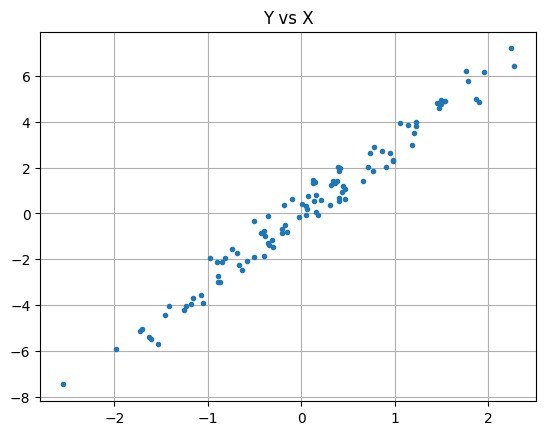

In [ ]:
np.random.seed(0) # para reproducibilidad
n_samples = 100
n_features = 1
beta = np.array([3])  
X = np.random.randn(n_samples, n_features)
epsilon = np.random.randn(n_samples)*0.5  
y = X.dot(beta) + epsilon

# Ploteo
fix, ax = plt.subplots()

ax.plot(X[:,0],y, '.')
ax.set_title(f"Y vs X")
ax.grid()


In [ ]:
X_with_intercept = np.column_stack((np.ones(n_samples), X))
beta_hat = np.linalg.inv(X_with_intercept.T.dot(X_with_intercept)).dot(X_with_intercept.T).dot(y)
print(beta_hat)

[0.03757654 3.05734922]


In [ ]:
iterations = 1_000
betas_hat = np.zeros([iterations,2])
for _ in range(iterations):
    X = np.random.randn(n_samples, n_features)
    epsilon = np.random.randn(n_samples)*0.5  
    y = X.dot(beta) + epsilon
    X_with_intercept = np.column_stack((np.ones(n_samples), X))
    beta_hat = np.linalg.inv(X_with_intercept.T.dot(X_with_intercept)).dot(X_with_intercept.T).dot(y)
    betas_hat[_,:] = beta_hat


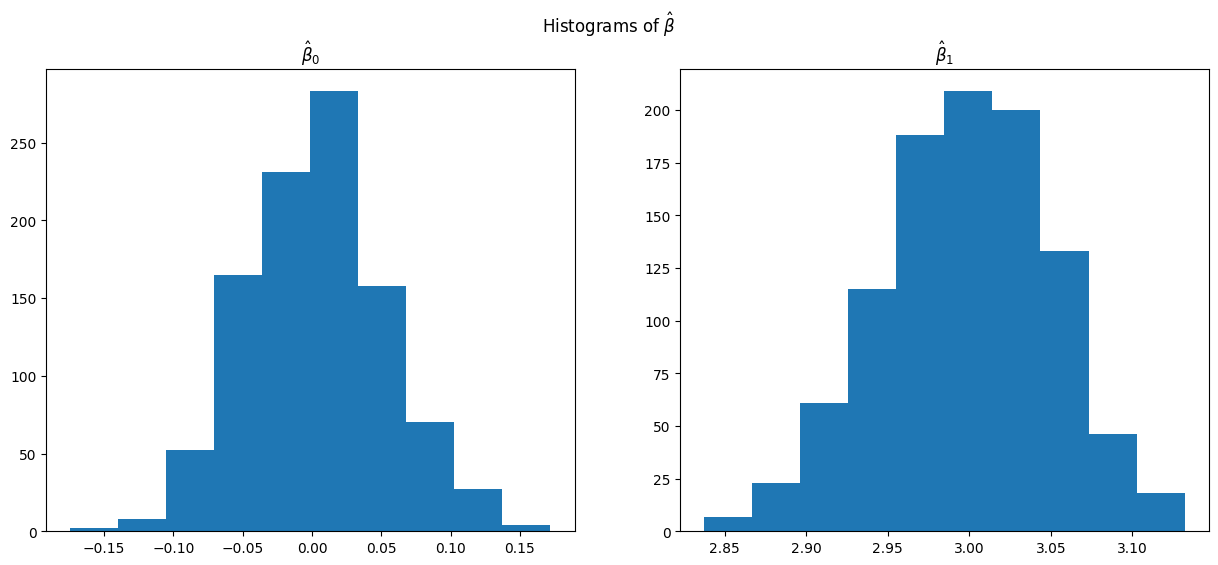

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,6))
plt.suptitle(r"Histograms of $\hat\beta$")
for i in range(2):
    ax[i].hist(betas_hat[:,i])
    ax[i].set_title(f"$\\hat\\beta_{i}$")

In [ ]:
pd.DataFrame(betas_hat).describe().T

,count,mean,std,min,25%,50%,75%,max
0,1000.0,0.003424,0.049902,-0.174432,-0.031672,0.005148,0.034657,0.172037
1,1000.0,2.997888,0.051616,2.837396,2.962548,2.999458,3.033729,3.132042


Reproduzcamos lo mismo en su versión bayesiana

In [ ]:
#Reproduzcamos lo mismo en su versión bayesiana
np.random.seed(0) # para reproducibilidad
n_samples = 100
n_features = 1
beta = np.array([3])  
X = np.random.randn(n_samples)
epsilon = np.random.randn(n_samples)*0.5  
y = beta*X + epsilon

In [ ]:
with pm.Model() as model:
    b0 = pm.Uniform("b0",-100,100)
    b1 = pm.Uniform("b1",-100,100)
    epsilon = pm.Uniform("epsilon",0,100)
    mu = b0 + b1*X
    predicted = pm.Normal("predicted",mu = mu, sigma = epsilon, observed = y) 
    trace = pm.sample(1_000,tune = 1_000)
model 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1, epsilon]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


       b0 ~ Uniform(-100, 100)
       b1 ~ Uniform(-100, 100)
  epsilon ~ Uniform(0, 100)
predicted ~ Normal(f(b0, b1), epsilon)

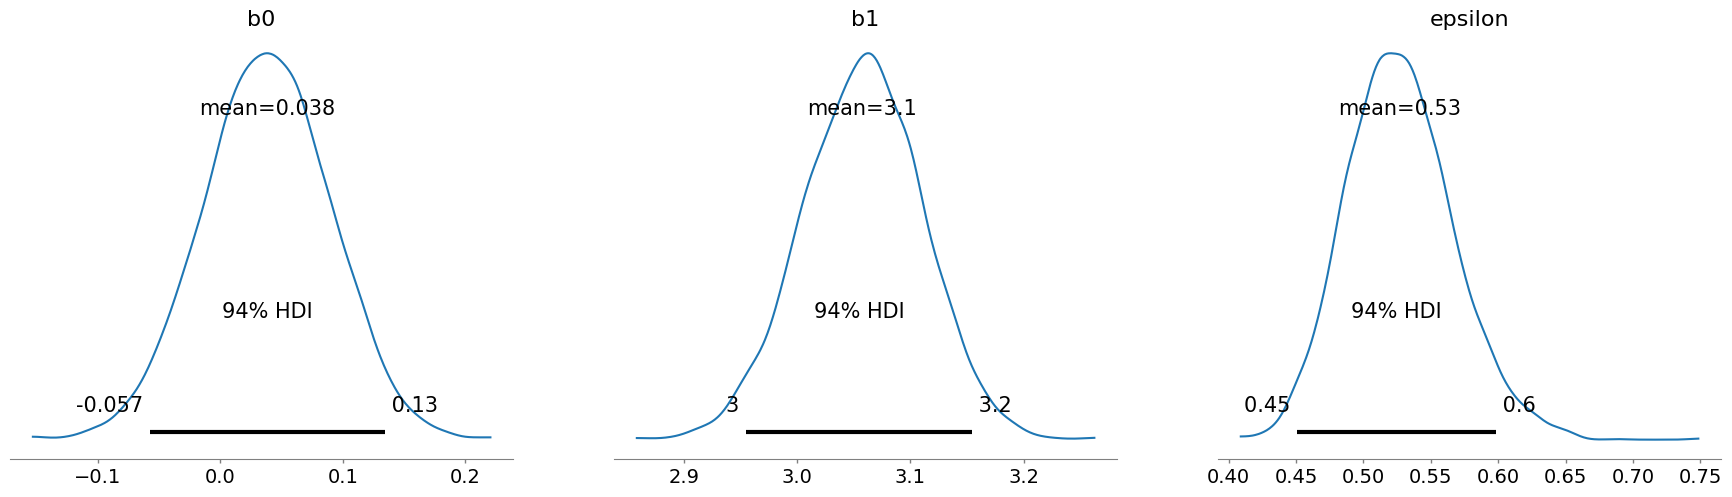

In [ ]:
az.plot_posterior(trace);

In [ ]:
az.summary(trace,kind="stats")

,mean,sd,hdi_3%,hdi_97%
b0,0.038,0.052,-0.057,0.134
b1,3.057,0.053,2.955,3.154
epsilon,0.527,0.039,0.451,0.598
